In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import scipy.io
# from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import time
from timeit import default_timer as timer

## Process the data

In [16]:
# load the data
h_t = np.loadtxt("..\..\Data\data_39_highSI.txt", dtype=float)

h_t = h_t[h_t>0]
h_t = h_t[1::20]

avr = np.average(h_t)
h_t = h_t/avr
# h_t = h_t.reshape(-1,1)

## Initialize the parameters

In [17]:
Nt = 7500       # train len for each iteration
Ntest = 2500      # test len
Nc = 500         # sample len to initialize the state
k = (len(h_t) - Nt) // Ntest
# k = 1
Ns = Nt+k*Ntest       # total sample len
M = 20           # size of input data
outSize = 1     # size of output
N = 50          # size of the reservoir
a = 1           # leaking rate

In [18]:
# generate Win and W randomly
np.random.seed(42)

W = np.random.rand(N, N) - 0.5
print('Computing spectral radius...')
rhoW = max(abs(linalg.eig(W)[0]))
print('done.')
W *= 1.25 / rhoW

Wi = np.random.rand(N, 1+M) - 0.5

Y = np.zeros((outSize, Ns-Nt), dtype=float)
h_predict = np.zeros(Ntest)

Computing spectral radius...
done.


## Training & testing process

In [19]:
for i, n in enumerate(np.arange(Nt, Ns, Ntest)):

    # allocated memory for the design (collected states) matrix
    X = np.zeros((1+M+N, Nt-Nc), dtype=float)
    Ytrain=np.array([[j for j in h_t[Nc+i*Ntest+M+n:Nt+i*Ntest+M+n]] for n in range(outSize)])[:,:]

    x = np.zeros((N,1), dtype=float)
    st = time.time()

    for t in np.arange(i*Ntest, Nt+i*Ntest):
        u = h_t[t:t+M, None]
        x = (1-a)*x + a*np.tanh(np.dot(Wi, np.vstack((1,u))) + np.dot(W, x))
        if t >= i*Ntest+Nc:
            X[:,t-Nc-i*Ntest] = np.vstack((1,u,x))[:,0]

    reg = 1e-8  # regularization coefficient

    Wo = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+M+N), np.dot(X,Ytrain.T) ).T

    et = time.time()

    print('Training time = ', et-st)

    # predict part
    x = np.zeros((N,1), dtype=float)
    Yt = np.zeros((outSize, Nt+Ntest), dtype=float)

    st = time.time()

    for t in np.arange(i*Ntest, Nt+(i+1)*Ntest):
        u = h_t[t:t+M, None]
        x = (1-a)*x + a*np.tanh(np.dot(Wi, np.vstack((1,u))) + np.dot(W, x))
        if t >= i*Ntest+Nc:
            y = np.dot(Wo, np.vstack((1,u,x)))
            Yt[:, t-i*Ntest] = y.ravel()

    et = time.time()
    print('Predictng time = ', et-st)   
    
    h_predict = Yt[:,Nt:Nt+Ntest]
    Y[:, i*Ntest:(i+1)*Ntest] = h_predict
    
    print(i)

Training time =  0.06800341606140137
Predictng time =  0.09262871742248535
0


In [20]:
j=0
Y_test = h_t[Nt+M+j:Ns+M+j].reshape(1,-1)
Y_pred = Y[j,:].reshape(1,-1)
MAE = mean_absolute_error(Y_test, Y_pred)

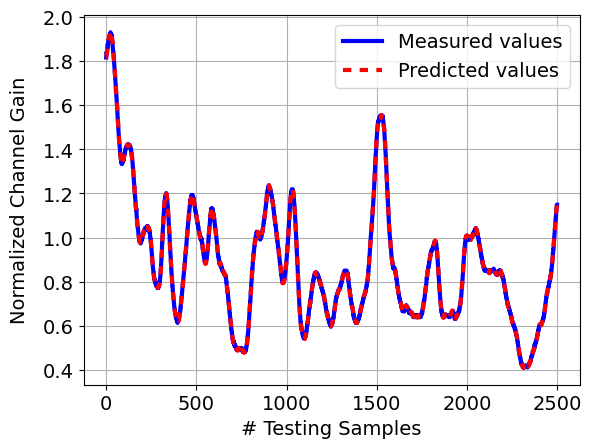

In [21]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,1)
ax.plot( Y_test.T, label='Measured values', color='b', linewidth=3.0)
ax.plot(Y_pred.T, linestyle='--', dashes=(2,2),  color='r', label='Predicted values', linewidth=3.0)
ax.set_ylabel('Normalized Channel Gain', labelpad=10)
ax.set_xlabel('# Testing Samples')
# ax.set_ylim(0, 2)
ax.grid()
ax.legend()
plt.show()

In [22]:
# MAE = np.zeros((outSize))

# for j in range(outSize):
#     Y_test = h_t[Nt+M+j:Ns+M+j].reshape(1,-1)
#     Y_pred = Y[j,:].reshape(1,-1)

#     MAE[j] = mean_absolute_error(Y_test, Y_pred)

#     np.savetxt("../../Data/Multi-step-ESN/lowSI_39/real_" + str(j)+ ".txt", Y_test, delimiter = '\n')
#     np.savetxt("../../Data/Multi-step-ESN/lowSI_39/predicted_" + str(j)+ ".txt", Y_pred, delimiter = '\n')

# print(MAE)
# np.savetxt("../../Data/Multi-step-ESN/lowSI_39/MAE.txt", MAE, delimiter='\n')

In [23]:
# MAE = np.zeros((outSize-2))

# for j in range(1, outSize-1):
#     Y_test = h_t[Nt+M+j:Ns+M+j].reshape(1,-1)
#     Y_pred = Y[j,:].reshape(1,-1)

#     MAE[j-1] = mean_absolute_error(Y_test, Y_pred)

#     np.savetxt("../../Data/Multi-step-ESN/highSI_39/real_" + str(j-1)+ ".txt", Y_test, delimiter = '\n')
#     np.savetxt("../../Data/Multi-step-ESN/highSI_39/predicted_" + str(j-1)+ ".txt", Y_pred, delimiter = '\n')

# print(MAE)
# np.savetxt("../../Data/Multi-step-ESN/highSI_39/MAE.txt", MAE, delimiter='\n')